In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import InterpolationMode
import cv2
import math

In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
pretrained_model = "../model/googlefonts2.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [6]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)

In [7]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [8]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [9]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [10]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode="bilinear"):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s, device="cuda") for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor).to("cuda")

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer("grid", grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode, padding_mode="border")

In [11]:
def attack(data, data_grad, target, dirname_res, dirname_pro, chr, count, epsilon, lim, success):
    os.makedirs(dirname_pro + chr + "/{}".format(count), exist_ok=True)
    # os.makedirs(dirname_pro + chr + "/{}".format(i), exist_ok=True)
    for i in range(1, 10001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        # perturbed_data += (perturbed_data < torch.Tensor([1 - lim]).to("cuda")) * epsilon + (perturbed_data < torch.Tensor([0]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([-1 + lim]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([0]).to("cuda")) * epsilon
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        # plt.xticks([], [])
        # plt.yticks([], [])
        # plt.imsave(dirname_pro + chr + "/{}".format(count) + "/" + "{}.png".format(i), data.squeeze().detach().cpu().numpy(), cmap="gray")
        if pred.item() != target.item():
            success += 1
            break
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    # os.makedirs(dirname_res + chr + "/{}".format(i), exist_ok=True)
    # plt.xticks([], [])
    # plt.yticks([], [])
    # plt.imsave(dirname_res + chr + "/{}".format(i) + "/" + "{}.png".format(count), data.squeeze().detach().cpu().numpy(), cmap="gray")
    return data, pred, success, i

In [15]:
def imshow(img):
    img = make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/home/hoge/.local/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 15%|█▌        | 4748/30862 [01:35<08:44, 49.78it/s] 


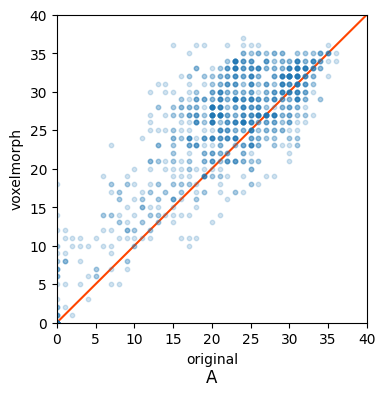

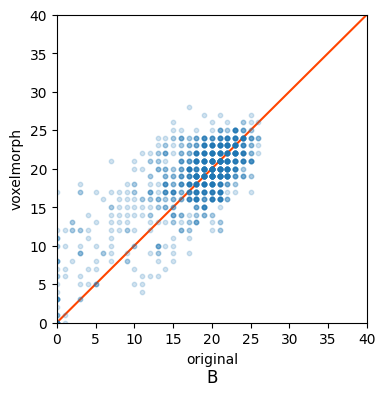

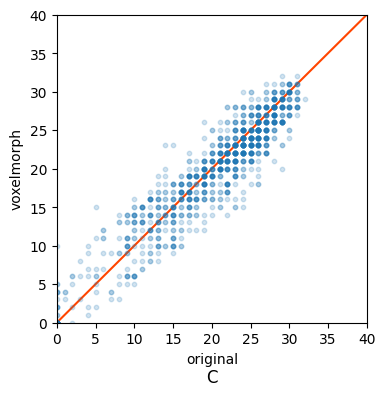

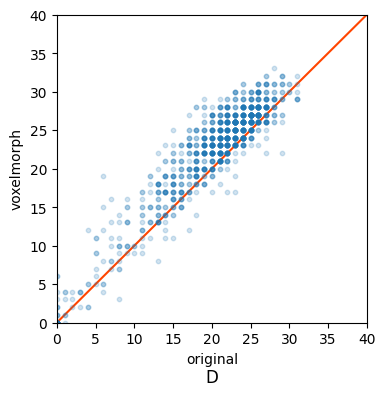

In [16]:
for lamda in [10]:
    chr_lambda = lambda a: chr(a + 65)
    dirname_org = "../attack_result_voxelmorph_test_DT".format(lamda) + "/org/"
    dirname_vxm = "../attack_result_voxelmorph_test_DT".format(lamda) + "/vxm/"
    dirname_org_adv = "../attack_result_voxelmorph_test_DT".format(lamda) + "/org_adv/"
    dirname_vxm_adv = "../attack_result_voxelmorph_test_DT".format(lamda) + "/vxm_adv/"
    dirname_org_res = "../attack_result_voxelmorph_test_DT".format(lamda) + "/org_resistance/"
    dirname_vxm_res = "../attack_result_voxelmorph_test_DT".format(lamda) + "/vxm_resistance/"
    dirname_org_pro = "../attack_result_voxelmorph_test_DT".format(lamda) + "/org_progress/"
    dirname_vxm_pro = "../attack_result_voxelmorph_test_DT".format(lamda) + "/vxm_progress/"
    dirname_vxm_graph = "../attack_result_voxelmorph_test_DT".format(lamda) + "/graph/"
    dirname_vxm_flow = "../attack_result_voxelmorph_test_DT".format(lamda) + "/flow/"
    os.makedirs(dirname_vxm_graph, exist_ok=True)
    for c in [chr(i) for i in range(65, 65+26)]:
        os.makedirs(dirname_org + c, exist_ok=True)
        os.makedirs(dirname_vxm + c, exist_ok=True)
        os.makedirs(dirname_org_adv + c, exist_ok=True)
        os.makedirs(dirname_vxm_adv + c, exist_ok=True)
        os.makedirs(dirname_org_res + c, exist_ok=True)
        os.makedirs(dirname_vxm_res + c, exist_ok=True)
        os.makedirs(dirname_org_pro + c, exist_ok=True)
        os.makedirs(dirname_vxm_pro + c, exist_ok=True)
        os.makedirs(dirname_vxm_flow + c, exist_ok=True)
        # for d in [chr(i) for i in range(65, 65+26)]:
        #     os.makedirs(dirname_org_adv + c + "/" + c + "→" + d, exist_ok=True)
        #     os.makedirs(dirname_vxm_adv + c + "/" + c + "→" + d, exist_ok=True)


    class ImageTransform():
        def __init__(self, mean, std):
            self.data_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Resize((64, 64), interpolation=InterpolationMode.NEAREST),
            transforms.Normalize(mean, std)
            ])

        def __call__(self, img):
            return self.data_transform(img)
    mean = (0.5,)
    std = (0.5,)
    images_test = ImageFolder( "../data/GoogleFonts/test2", transform = ImageTransform(mean, std))
    batch_size = 1
    test_loader = DataLoader(images_test, batch_size = batch_size, shuffle = False, drop_last=True)

    # 精度カウンター
    success = 0
    # count = 0
    count_list = [0] * 26

    adv_examples = []
    # i=0
    a_list = []
    # テスト用データセット内の全てのサンプルをループします
    



    vxm = UNet(n_channels=1, n_classes=2).to(device)
    transformer = SpatialTransformer(size=(64, 64))


    for alphabet in range(4):
        org_d = []
        vxm_d = []
        # vxm.load_state_dict(torch.load("../model/voxelmorph/" + chr(alphabet + 65) + "/weight/" + chr(alphabet + 65) +"_lamda{}.pth".format(lamda), map_location='cpu'))
        vxm.load_state_dict(torch.load("../attack_result_voxelmorph_test_MSE/model/" + chr(alphabet + 65) +"_DT.pth", map_location='cpu'))
        vxm.eval()
        for data, target in tqdm(test_loader, total = 30862):
            # データとラベルをデバイス（CPUもしくはGPU）に送信します
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
            data.requires_grad = True
            # データをモデルに順伝播させます
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

            # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
            if target.item() == alphabet + 1:
                break

            if target.item() != alphabet:
                continue

            if init_pred.item() != target.item():
                count_list[target.item()] += 1
                org_d.append(0)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_org + chr_lambda(target.item()) + "/{}.png".format(count_list[target.item()]), data.squeeze().detach().cpu().numpy(), cmap="gray")
                # os.makedirs(dirname_org_res + chr_lambda(target.item()) + "/0", exist_ok=True)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_org_res + chr_lambda(target.item()) + "/0/" + "{}.png".format(count_list[target.item()]), data.squeeze().detach().cpu().numpy(), cmap="gray")

            else:
                data_copy = data.detach().clone()
                count_list[init_pred.item()] += 1
                # 損失を計算します
                loss = F.nll_loss(output, target)
                # 既存の勾配を全てゼロにします
                model.zero_grad()
                # 逆伝播させてモデルの勾配を計算します
                loss.backward()
                # データの勾配を取得します
                data_grad = data.grad.data
                perturbed_data, pred, success, defensibility = attack(data, data_grad, target, dirname_org_res, dirname_org_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.02, 0, success)
                org_d.append(defensibility)
                final_pred = pred
                org = data_copy.squeeze().detach().cpu().numpy()
                adv = perturbed_data.squeeze().detach().cpu().numpy()
                
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_org + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), org, cmap="gray")
                # os.makedirs(dirname_org_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/", exist_ok=True)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_org_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), adv, cmap="gray")


            data.requires_grad = False
            flow = vxm(data)
            # f = flow[0].detach().clone().cpu()
            # H = []
            # S = []
            # for i in range(64):
            #     h = []
            #     s = []
            #     for j in range(64):
            #         length = np.sqrt(f[0][i][j] ** 2 + f[1][i][j] ** 2)
            #         if f[0][i][j] < 0:
            #             h.append(180 - (math.degrees(math.acos(f[1][i][j] / length)) / 2))
            #         else:
            #             h.append(math.degrees(math.acos(f[1][i][j] / length)) / 2)
            #         s.append(length)
            #     H.append(h)
            #     S.append(s)
            # H = np.array(H)
            # S = np.array(S)
            # S_max = S.max()
            # S = (S / S_max) * 255
            # V = np.ones([64, 64]) * 255
            # optical_f = np.array([H, S, V]).transpose(1, 2, 0).astype(np.uint8)
            # img = cv2.cvtColor(optical_f,cv2.COLOR_HSV2BGR)
            # plt.xticks([], [])
            # plt.yticks([], [])
            # plt.imsave(dirname_vxm_flow + chr_lambda(target.item()) + "/{}.png".format(count_list[target.item()]), img, cmap="gray")
            data = transformer(data, flow)
            data = Variable(data).to(device)
            # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

            # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。


            if init_pred.item() != target.item():
                vxm_d.append(0)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_vxm + chr_lambda(target.item()) + "/{}.png".format(count_list[target.item()]), data.squeeze().detach().cpu().numpy(), cmap="gray")
                # os.makedirs(dirname_vxm_res + chr_lambda(target.item()) + "/0", exist_ok=True)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_vxm_res + chr_lambda(target.item()) + "/0/" + "{}.png".format(count_list[target.item()]), data.squeeze().detach().cpu().numpy(), cmap="gray")

            else:
                data_copy = data.detach().clone()
                # 損失を計算します
                loss = F.nll_loss(output, target)
                # 既存の勾配を全てゼロにします
                model.zero_grad()
                # 逆伝播させてモデルの勾配を計算します
                loss.backward()
                # データの勾配を取得します
                data_grad = data.grad.data
                perturbed_data, pred, success, defensibility = attack(data, data_grad, target, dirname_vxm_res, dirname_vxm_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.02, 0, success)
                vxm_d.append(defensibility)
                final_pred = pred
                org = data_copy.squeeze().detach().cpu().numpy()
                adv = perturbed_data.squeeze().detach().cpu().numpy()
                # if count_list[target.item()] % 100 == 0:
                #     iterator = list(iter(data))
                #     imshow(iterator)
                #各条件を満たす画像の保存
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_vxm + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), org, cmap="gray")
                # os.makedirs(dirname_vxm_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/", exist_ok=True)
                # plt.xticks([], [])
                # plt.yticks([], [])
                # plt.imsave(dirname_vxm_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), adv, cmap="gray")
        plt.figure(figsize=(4,4))
        x = np.array([0, 40])
        y = x
        plt.scatter(org_d, vxm_d, zorder=2, s=10, alpha=0.2)
        plt.plot(x, y, color = "orangered", zorder=1)
        plt.xlim(0, 40)
        plt.ylim(0, 40)
        plt.xticks(np.arange(0, 41, step=5))
        plt.yticks(np.arange(0, 41, step=5))
        plt.xlabel("original")
        plt.ylabel("voxelmorph")
        plt.title(chr(alphabet + 65), y=-0.22)
        # plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
        # plt.savefig("../GoogleFonts_reg/y_y/reg_" + chr(index + 65) + ".png", facecolor="white")
        plt.savefig("../attack_result_voxelmorph_test_DT/graph/".format(lamda) + chr(alphabet + 65) + ".png", bbox_inches='tight')

In [17]:
# plt.figure(figsize=(20,5))
# plt.scatter(x2, y2)
# plt.show()

In [18]:
# plt.figure(figsize=(4,4))
# x = np.array([0, 40])
# y = x
# plt.scatter(org_d, vxm_d, zorder=2, s=10, alpha=0.2)
# plt.plot(x, y, color = "orangered", zorder=1)
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.xlabel("original")
# plt.ylabel("voxelmorph")
# plt.title(chr(alphabet + 65), y=-0.25)
# # plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
# # plt.savefig("../GoogleFonts_reg/y_y/reg_" + chr(index + 65) + ".png", facecolor="white")
# plt.savefig("../attack_result_voxelporph_lamda10/graph.png", bbox_inches='tight')
# # plt.show()
# # np.mean(vxm_d)


In [19]:
num_list_3 = [yy - xx for xx, yy in zip(org_d, vxm_d) if xx != 0 and yy != 0]
l = [a for a in num_list_3 if a > 0]
print(org_d)
print(vxm_d)
print(len(num_list_3))
print(len(l))

[26, 7, 23, 25, 21, 22, 16, 15, 25, 20, 23, 2, 24, 27, 22, 17, 22, 20, 7, 23, 23, 19, 0, 5, 26, 2, 18, 19, 23, 23, 24, 19, 26, 25, 21, 20, 24, 23, 0, 19, 19, 22, 25, 20, 0, 20, 14, 24, 23, 0, 22, 20, 24, 26, 24, 20, 25, 26, 27, 23, 31, 0, 14, 24, 17, 26, 25, 22, 23, 24, 21, 22, 17, 22, 20, 25, 22, 18, 22, 19, 23, 19, 25, 22, 16, 18, 11, 6, 0, 22, 23, 10, 21, 16, 25, 18, 19, 22, 22, 16, 25, 23, 0, 21, 22, 21, 24, 4, 22, 21, 26, 20, 26, 22, 21, 25, 20, 21, 25, 22, 19, 14, 26, 20, 22, 15, 21, 19, 25, 22, 15, 18, 26, 22, 26, 15, 24, 2, 26, 26, 20, 21, 24, 25, 26, 23, 21, 26, 14, 23, 27, 18, 27, 21, 31, 25, 22, 21, 15, 14, 21, 25, 23, 1, 23, 5, 19, 25, 13, 23, 21, 24, 17, 8, 13, 22, 26, 25, 8, 27, 24, 14, 24, 20, 14, 22, 31, 23, 26, 28, 14, 25, 26, 15, 26, 22, 13, 15, 20, 23, 15, 20, 22, 24, 24, 18, 23, 26, 19, 24, 27, 16, 24, 26, 15, 25, 24, 25, 11, 26, 20, 20, 13, 23, 24, 17, 23, 28, 12, 23, 24, 16, 23, 20, 22, 12, 14, 28, 13, 12, 13, 26, 24, 25, 31, 23, 23, 26, 17, 24, 12, 22, 20, 18, 27